# Segmenting and Clustering Neighborhood of Toronto

I put all parts in one notebook, please use this to jump to respective parts

<ul>
    <li><a href="#part1">PART 1</a></li>
    <li><a href="#part2">PART 2</a></li>
    <li><a href="#part3">PART 3</a></li>
</ul>

## Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


<a id="part1"></a>

## PART 1

## 1. Get Toronto Neighborhood

Get Toronto Neighborhood from Wikipedia, scrap directly with pandas, look for table contains 'Postal Code'

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
df,=pd.read_html(url,match='Postal Code')

df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Drop unassigned borough

In [4]:
df = df[df["Borough"] != "Not assigned"].reset_index(drop=True)

### Take care of unassigned Neighborhood

In [5]:
df[df["Neighbourhood"] == "Not assigned"]

,Postal Code,Borough,Neighbourhood


No Neighbordood is unassigned, so no action needed

### Merge Neighborhood which has same Postal Code

In [6]:
df['Postal Code'].value_counts().to_frame().describe()

,Postal Code
count,103.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


One postal code contains exactly one neighborhood, so no need to tansform

In [140]:
df.shape

(103, 5)

<a id="part2"></a>
## PART 2

### Get Neighborhood Coordinate
I decide to use ArcGIS geolocator since it support search by Postal Code, also use ratelimit to deal with API max call

In [7]:
df['latitude'] = np.nan
df['longitude'] = np.nan

df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,NaN,NaN
1,M4A,North York,Victoria Village,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",NaN,NaN
3,M6A,North York,"Lawrence Manor, Lawrence Heights",NaN,NaN
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",NaN,NaN


In [9]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import ArcGIS


geolocator = ArcGIS(user_agent="ny_explorer")

for index, row in df.iterrows():
    locator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    location = locator("{}, Toronto, Ontario".format(row['Postal Code']))
    df.at[index, 'latitude'] = location.latitude
    df.at[index, 'longitude'] = location.longitude

df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


In [12]:
df[df['latitude'].isnull()]

,Postal Code,Borough,Neighbourhood,latitude,longitude


In [142]:
df.shape

(103, 5)

<a id="part3"><a>
## PART 3

## 2. Explore Neighborhoods of Toronto

Get Venues from Foursquare explore API, borrow Rate Limiter to deal with max API calls

In [14]:
# type your answer here

CLIENT_ID = 'HSBRYU4K213SYR52IULCEK4KOO5OO0YBTJARJ02KEZRPNJLT' # your Foursquare ID
CLIENT_SECRET = 'OLNDFZCO3MF5BZ3MAHC1NKB1YDEA4GDME5LEVI34CBVFXEUM' # your Foursquare Secret
ACCESS_TOKEN = '0MA4ZFGALG53LCAOC1OOPCIUZPABINDCUZPN1PFVHABR2SBQ' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        explorer = RateLimiter(requests.get, min_delay_seconds=1)
        results = explorer(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# type your answer here
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [16]:
toronto_venues.shape

(3310, 7)

In [17]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,Careful & Reliable Painting,43.752622,-79.331957,Construction & Landscaping
2,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.75245,-79.32991,649 Variety,43.754513,-79.331942,Convenience Store
4,Parkwoods,43.75245,-79.32991,GTA Restoration,43.753396,-79.333477,Fireworks Store


We got all venues and it's category

In [18]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,18,18,18,18,18,18
"Alderwood, Long Branch",5,5,5,5,5,5
"Bathurst Manor, Wilson Heights, Downsview North",1,1,1,1,1,1
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",41,41,41,41,41,41
...,...,...,...,...,...,...
"Willowdale, Willowdale West",8,8,8,8,8,8
Woburn,4,4,4,4,4,4
Woodbine Heights,26,26,26,26,26,26


even though we limit the venues to 100 looks like not much venues on the databases

In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 324 uniques categories.


## 3. Analyze Each Neighborhood

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,...,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_onehot.shape

(3310, 324)

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,...,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
94,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
95,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
96,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [23]:
toronto_grouped.shape

(98, 324)

In [24]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                 venue  freq
0   Chinese Restaurant  0.11
1            Newsagent  0.06
2       Discount Store  0.06
3        Shopping Mall  0.06
4  Shanghai Restaurant  0.06


----Alderwood, Long Branch----
                venue  freq
0                 Gym   0.2
1   Convenience Store   0.2
2  Athletics & Sports   0.2
3        Dance Studio   0.2
4                 Pub   0.2


----Bathurst Manor, Wilson Heights, Downsview North----
                             venue  freq
0                      Men's Store   1.0
1                      Yoga Studio   0.0
2  Molecular Gastronomy Restaurant   0.0
3                      Music Store   0.0
4                           Museum   0.0


----Bayview Village----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Park  0.33
2                       Trail  0.33
3                 Yoga Studio  0.00
4  Modern European Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                v

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [121]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Newsagent,Bubble Tea Shop,Badminton Court,Sushi Restaurant,Discount Store,Electronics Store,Department Store,Bakery,Supermarket
1,"Alderwood, Long Branch",Dance Studio,Convenience Store,Athletics & Sports,Pub,Gym,Women's Store,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Men's Store,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
3,Bayview Village,Trail,Construction & Landscaping,Park,Women's Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
4,"Bedford Park, Lawrence Manor East",Spa,Italian Restaurant,Sandwich Place,Sushi Restaurant,Mobile Phone Shop,Thai Restaurant,Hobby Shop,Coffee Shop,Japanese Restaurant,Sports Club


In [49]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Newsagent,Bubble Tea Shop,Badminton Court,Sushi Restaurant,Discount Store,Electronics Store,Department Store,Bakery,Supermarket
1,"Alderwood, Long Branch",Dance Studio,Convenience Store,Athletics & Sports,Pub,Gym,Women's Store,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Men's Store,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
3,Bayview Village,Trail,Construction & Landscaping,Park,Women's Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
4,"Bedford Park, Lawrence Manor East",Spa,Italian Restaurant,Sandwich Place,Sushi Restaurant,Mobile Phone Shop,Thai Restaurant,Hobby Shop,Coffee Shop,Japanese Restaurant,Sports Club


## 4. Cluster Neighborhoods

In [122]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123456).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 3, 1, 2, 2, 2, 2, 2, 2])

In [90]:
type(kmeans.labels_)

numpy.ndarray

In [29]:
kmeans.labels_.shape

(98,)

In [94]:
kmeans.cluster_centers_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.17116668e-03,  6.19343013e-03,  2.66383827e-03, ...,
         2.61919002e-03,  4.35334203e-04,  2.24575298e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.33680869e-19, -8.67361738e-19,  0.00000000e+00, ...,
         4.33680869e-19,  1.08420217e-19,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [95]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

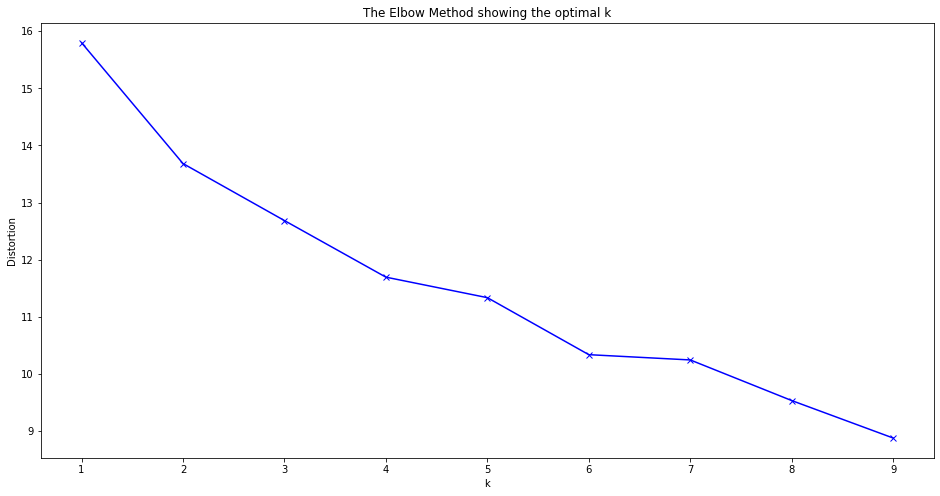

In [97]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 


plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [123]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

toronto_merged.rename(columns={'Neighbourhood':"Neighborhood"}, inplace=True)

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,2.0,Construction & Landscaping,Fireworks Store,Hotel,Bus Stop,Food & Drink Shop,BBQ Joint,Convenience Store,Park,Field,Escape Room
1,M4A,North York,Victoria Village,43.73057,-79.31306,1.0,Park,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2.0,Coffee Shop,Food Truck,Thai Restaurant,Breakfast Spot,Pub,Furniture / Home Store,Moving Target,Chinese Restaurant,Bakery,Italian Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2.0,Clothing Store,Women's Store,Coffee Shop,Restaurant,Jewelry Store,American Restaurant,Cosmetics Shop,Men's Store,Shoe Store,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,2.0,Coffee Shop,Sandwich Place,Sushi Restaurant,Mediterranean Restaurant,Italian Restaurant,Portuguese Restaurant,Café,Restaurant,Burrito Place,Pizza Place


In [124]:
toronto_merged[toronto_merged['Cluster Labels'].isnull()]

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,M1X,Scarborough,Upper Rouge,43.83412,-79.21668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [126]:
toronto_merged.dropna(axis=0, inplace=True)

In [127]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,2,Construction & Landscaping,Fireworks Store,Hotel,Bus Stop,Food & Drink Shop,BBQ Joint,Convenience Store,Park,Field,Escape Room
1,M4A,North York,Victoria Village,43.73057,-79.31306,1,Park,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,2,Coffee Shop,Food Truck,Thai Restaurant,Breakfast Spot,Pub,Furniture / Home Store,Moving Target,Chinese Restaurant,Bakery,Italian Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,2,Clothing Store,Women's Store,Coffee Shop,Restaurant,Jewelry Store,American Restaurant,Cosmetics Shop,Men's Store,Shoe Store,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,2,Coffee Shop,Sandwich Place,Sushi Restaurant,Mediterranean Restaurant,Italian Restaurant,Portuguese Restaurant,Café,Restaurant,Burrito Place,Pizza Place


In [128]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#rainbow

## 5. Examine Clusters

In [129]:
toronto_merged['Cluster Labels'].value_counts()

2    87
1    12
4     1
3     1
0     1
Name: Cluster Labels, dtype: int64

### Cluster 1

In [130]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,"Kingsview Village, St. Phillips, Martin Grove ...",0,Bus Line,Women's Store,Fireworks Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room


In [131]:
toronto_merged.loc[toronto_merged['Cluster Labels']==0]['1st Most Common Venue'].value_counts()

Bus Line    1
Name: 1st Most Common Venue, dtype: int64

### Cluster 2

In [132]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,1,Park,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
18,"Guildwood, Morningside, West Hill",1,Park,Gym / Fitness Center,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
22,Woburn,1,Construction & Landscaping,Business Service,Park,Coffee Shop,Women's Store,Ethiopian Restaurant,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
27,Hillcrest Village,1,Residential Building (Apartment / Condo),Park,Women's Store,Escape Room,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
35,"East Toronto, Broadview North (Old East York)",1,Film Studio,Convenience Store,Park,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
39,Bayview Village,1,Trail,Construction & Landscaping,Park,Women's Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
45,"York Mills, Silver Hills",1,Music Venue,Park,Escape Room,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
66,York Mills West,1,Convenience Store,Park,Coffee Shop,Women's Store,Event Service,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
69,"High Park, The Junction South",1,Park,Residential Building (Apartment / Condo),Intersection,Convenience Store,Event Service,Sandwich Place,Electronics Store,Dog Run,Donut Shop,Dry Cleaner
73,"North Toronto West, Lawrence Park",1,Park,Gym Pool,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School


In [133]:
toronto_merged.loc[toronto_merged['Cluster Labels']==1]['1st Most Common Venue'].value_counts()

Park                                        4
Rental Car Location                         1
Residential Building (Apartment / Condo)    1
Trail                                       1
Convenience Store                           1
Film Studio                                 1
Music Venue                                 1
Playground                                  1
Construction & Landscaping                  1
Name: 1st Most Common Venue, dtype: int64

### Cluster 3

In [134]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,2,Construction & Landscaping,Fireworks Store,Hotel,Bus Stop,Food & Drink Shop,BBQ Joint,Convenience Store,Park,Field,Escape Room
2,"Regent Park, Harbourfront",2,Coffee Shop,Food Truck,Thai Restaurant,Breakfast Spot,Pub,Furniture / Home Store,Moving Target,Chinese Restaurant,Bakery,Italian Restaurant
3,"Lawrence Manor, Lawrence Heights",2,Clothing Store,Women's Store,Coffee Shop,Restaurant,Jewelry Store,American Restaurant,Cosmetics Shop,Men's Store,Shoe Store,Furniture / Home Store
4,"Queen's Park, Ontario Provincial Government",2,Coffee Shop,Sandwich Place,Sushi Restaurant,Mediterranean Restaurant,Italian Restaurant,Portuguese Restaurant,Café,Restaurant,Burrito Place,Pizza Place
5,"Islington Avenue, Humber Valley Village",2,Pharmacy,Skating Rink,Shopping Mall,Bank,Grocery Store,Café,Home Service,Park,Fast Food Restaurant,Elementary School
...,...,...,...,...,...,...,...,...,...,...,...,...
97,"First Canadian Place, Underground city",2,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Seafood Restaurant,American Restaurant,Gastropub,Asian Restaurant
99,Church and Wellesley,2,Japanese Restaurant,Coffee Shop,Gay Bar,Burrito Place,Sushi Restaurant,Restaurant,Yoga Studio,Gym,Burger Joint,Café
100,"Business reply mail Processing Centre, South C...",2,Coffee Shop,Café,Restaurant,Gym,Hotel,Sushi Restaurant,Thai Restaurant,Steakhouse,Japanese Restaurant,Bar
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",2,Construction & Landscaping,Chinese Restaurant,Park,Sushi Restaurant,Fast Food Restaurant,Flower Shop,Coffee Shop,Italian Restaurant,Bank,Women's Store


In [135]:
toronto_merged.loc[toronto_merged['Cluster Labels']==2]['1st Most Common Venue'].value_counts()

Coffee Shop                   19
Pizza Place                    6
Spa                            6
Pharmacy                       5
Café                           4
Home Service                   3
Park                           3
Construction & Landscaping     3
Electronics Store              2
Clothing Store                 2
Restaurant                     2
Bar                            2
Ice Cream Shop                 2
Furniture / Home Store         2
Pet Store                      2
Miscellaneous Shop             1
College Stadium                1
ATM                            1
Trail                          1
Rental Service                 1
Dessert Shop                   1
Hotel                          1
Hockey Arena                   1
Japanese Restaurant            1
Bus Line                       1
Mobile Phone Shop              1
Italian Restaurant             1
Sporting Goods Shop            1
Sushi Restaurant               1
Moving Target                  1
College Re

### Cluster 4

In [136]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,"Bathurst Manor, Wilson Heights, Downsview North",3,Men's Store,Women's Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room


In [137]:
toronto_merged.loc[toronto_merged['Cluster Labels']==3]['1st Most Common Venue'].value_counts()

Men's Store    1
Name: 1st Most Common Venue, dtype: int64

### Cluster 5

In [138]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Cedarbrae,4,Lounge,Women's Store,Event Service,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant


### Interpretation

Cluster 1 only consists of 1 neighborhood, and it mainly features bus line and women's store. Cluster 2 mainly features parks, palygrounds and outdoors. Cluster 3 has most neighborhood, featuring all public facilities, like general neighborhood. Cluster 4 mainly features Men's Store. Cluster 5 features Lounge and Women's Store

Based on elbow method analysis, actually there won't be optimal clusters, since the elbow is not perfectly shape. As we can see if we choose to cluster it into 5 clusters, some clusters only has 1 member. And some clusters are similar, i.e: cluster 1 and cluster 5.
